# Direct sampling with Gaussian process regression

#### Import general modules

mpi4py is always required when using these tools. Numpy is always good to have if any manipulation is to be done.

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

import os
os.environ["PYSEMTOOLS_DEBUG"] = 'false'
os.environ["PYSEMTOOLS_HIDE_LOG"] = 'false'

#### Import modules from pysemtools

In this case we will import all the data types that we currently support, as well as io functions that are required to populate them.

In [2]:
# Data types
from pysemtools.datatypes.msh import Mesh
from pysemtools.datatypes.coef import Coef
from pysemtools.datatypes.field import Field, FieldRegistry

# Readers
from pysemtools.io.ppymech.neksuite import preadnek, pynekread

# Writers
from pysemtools.io.ppymech.neksuite import pwritenek, pynekwrite

fname = '../data/mixlay0.f00001'

## Read the data

In [3]:
# Read the data
msh = Mesh(comm, create_connectivity=False)
fld = FieldRegistry(comm)
pynekread(fname, comm, data_dtype=np.double, msh = msh, fld = fld)
 
# Get the coefficients
coef = Coef(msh=msh, comm=comm)

2025-02-25 16:06:06,875 - Mesh - INFO - Initializing empty Mesh object.
2025-02-25 16:06:06,877 - Field - INFO - Initializing empty Field object
2025-02-25 16:06:06,878 - pynekread - INFO - Reading file: ../data/mixlay0.f00001
2025-02-25 16:06:06,884 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-02-25 16:06:06,884 - Mesh - INFO - Initializing common attributes.
2025-02-25 16:06:06,885 - Mesh - INFO - Getting vertices
2025-02-25 16:06:06,886 - Mesh - INFO - Getting edge centers
2025-02-25 16:06:06,892 - Mesh - INFO - Facet centers not available for 2D
2025-02-25 16:06:06,894 - Mesh - INFO - Mesh object initialized.
2025-02-25 16:06:06,895 - Mesh - INFO - Mesh data is of type: float64
2025-02-25 16:06:06,895 - Mesh - INFO - Elapsed time: 0.011792229999999997s
2025-02-25 16:06:06,896 - pynekread - INFO - Reading field data
2025-02-25 16:06:06,903 - pynekread - INFO - File read
2025-02-25 16:06:06,904 - pynekread - INFO - Elapsed time: 0.025885378s
2025-02-25 16:06:06,

## Compress the data with GPR

### Initialize the Direct sampler

In [4]:
from pysemtools.compression.gpc_direct_sampling import DirectSampler

# Initialize a sampler with numpy (default)
ds = DirectSampler(comm=comm, msh=msh)

# Initialize a sampler with the torch backend
ds_torch = DirectSampler(comm=comm, msh=msh, bckend='torch')


2025-02-25 16:06:08,194 - DirectSampler - INFO - Initializing the DirectSampler from a Mesh object
2025-02-25 16:06:08,200 - DirectSampler - INFO - Initializing the DirectSampler from a Mesh object


### Sample the data

In [5]:
# Select the options
n_samples = 16+8 # To compare with the svd, since each element will save 16 coefficients
bitrate = n_samples/(msh.lx*msh.ly*msh.lz)
ds.log.tic()
ds.sample_field(field=fld.registry["u"], field_name="u", covariance_method="average", covariance_elements_to_average=100, compression_method="fixed_bitrate", bitrate = bitrate)
ds.log.toc()

# Keep modes to 16 to keep the same amount of data between the 2 versions
n_samples = 8  
bitrate = n_samples/(msh.lx*msh.ly*msh.lz)
ds_torch.log.tic()
ds_torch.sample_field(field=fld.registry["u"], field_name="u", covariance_method="svd", covariance_keep_modes=16, compression_method="fixed_bitrate", bitrate = bitrate, max_samples_per_it=1)
ds_torch.log.toc()

2025-02-25 16:06:08,215 - DirectSampler - INFO - Sampling the field with options: covariance_method: {covariance_method}, compression_method: {compression_method}
2025-02-25 16:06:08,216 - DirectSampler - INFO - Estimating the covariance matrix
2025-02-25 16:06:08,217 - DirectSampler - INFO - Transforming the field into to legendre space
2025-02-25 16:06:08,220 - DirectSampler - INFO - Estimating the covariance matrix using the averaging method method. Averaging over 100 elements at a time
2025-02-25 16:06:08,221 - DirectSampler - INFO - Covariance saved in field uncompressed_data["u"]["kw"]
2025-02-25 16:06:08,222 - DirectSampler - INFO - Sampling the field using the fixed bitrate method. using settings: {'method': 'fixed_bitrate', 'bitrate': np.float64(0.375), 'n_samples': 24}
2025-02-25 16:06:08,223 - DirectSampler - INFO - Proccesing up to 1600/1600 element
2025-02-25 16:06:09,903 - DirectSampler - INFO - Sampled_field saved in field uncompressed_data["u"]["field"]
2025-02-25 16:06

### Encode it

In [6]:
ds.compress_samples(lossless_compressor="bzip2")

ds_torch.compress_samples(lossless_compressor="bzip2")

2025-02-25 16:06:11,347 - DirectSampler - INFO - Compressing the data using the lossless compressor: bzip2
2025-02-25 16:06:11,348 - DirectSampler - INFO - Compressing data in uncompressed_data
2025-02-25 16:06:11,349 - DirectSampler - INFO - Compressing data for field ["u"]:
2025-02-25 16:06:11,349 - DirectSampler - INFO - Compressing ["kw"] for field ["u"]
2025-02-25 16:06:11,353 - DirectSampler - INFO - Compressing ["field"] for field ["u"]
2025-02-25 16:06:11,430 - DirectSampler - INFO - Compressing the data using the lossless compressor: bzip2
2025-02-25 16:06:11,431 - DirectSampler - INFO - Compressing data in uncompressed_data
2025-02-25 16:06:11,432 - DirectSampler - INFO - Compressing data for field ["u"]:
2025-02-25 16:06:11,432 - DirectSampler - INFO - Compressing ["U"] for field ["u"]
2025-02-25 16:06:11,455 - DirectSampler - INFO - Compressing ["s"] for field ["u"]
2025-02-25 16:06:11,457 - DirectSampler - INFO - Compressing ["Vt"] for field ["u"]
2025-02-25 16:06:11,459 -

### Write it out

In [7]:
ds.write_compressed_samples(comm=comm, filename="test")

ds_torch.write_compressed_samples(comm=comm, filename="test_torch")

2025-02-25 16:06:11,625 - DirectSampler - INFO - Parallel HDF5 not available; creating folder to store rank files.
2025-02-25 16:06:11,630 - DirectSampler - INFO - Parallel HDF5 not available; creating folder to store rank files.


## Decompress the data

### Read the data

In [8]:
ds_read = DirectSampler(comm, filename="test")
ds_torch_read = DirectSampler(comm, filename="test_torch", bckend='torch')

2025-02-25 16:06:11,642 - DirectSampler - INFO - Initializing the DirectSampler from file: test
2025-02-25 16:06:11,673 - DirectSampler - INFO - Initializing the DirectSampler from file: test_torch


### Reconstruct the data from the samples

In [9]:
u_np, u_std_np = ds_read.reconstruct_field(field_name="u", get_mean=True, get_std=True)

u_d, u_std_d = ds_torch_read.reconstruct_field(field_name="u", get_mean=True, get_std=True)

2025-02-25 16:06:11,725 - DirectSampler - INFO - Proccesing up to 1600/1600 element
2025-02-25 16:06:11,901 - DirectSampler - INFO - Processing up to 256/1600 elements
2025-02-25 16:06:11,920 - DirectSampler - INFO - Processing up to 512/1600 elements
2025-02-25 16:06:11,932 - DirectSampler - INFO - Processing up to 768/1600 elements
2025-02-25 16:06:11,944 - DirectSampler - INFO - Processing up to 1024/1600 elements
2025-02-25 16:06:11,959 - DirectSampler - INFO - Processing up to 1280/1600 elements
2025-02-25 16:06:11,972 - DirectSampler - INFO - Processing up to 1536/1600 elements
2025-02-25 16:06:11,986 - DirectSampler - INFO - Processing up to 1600/1600 elements


## Visualize the data

In [10]:
# General settings

u = fld.registry["u"]
u_levels = np.linspace(np.min(u), np.max(u), 100)
err_levels = np.linspace(0, 0.5, 100)

### Numpy

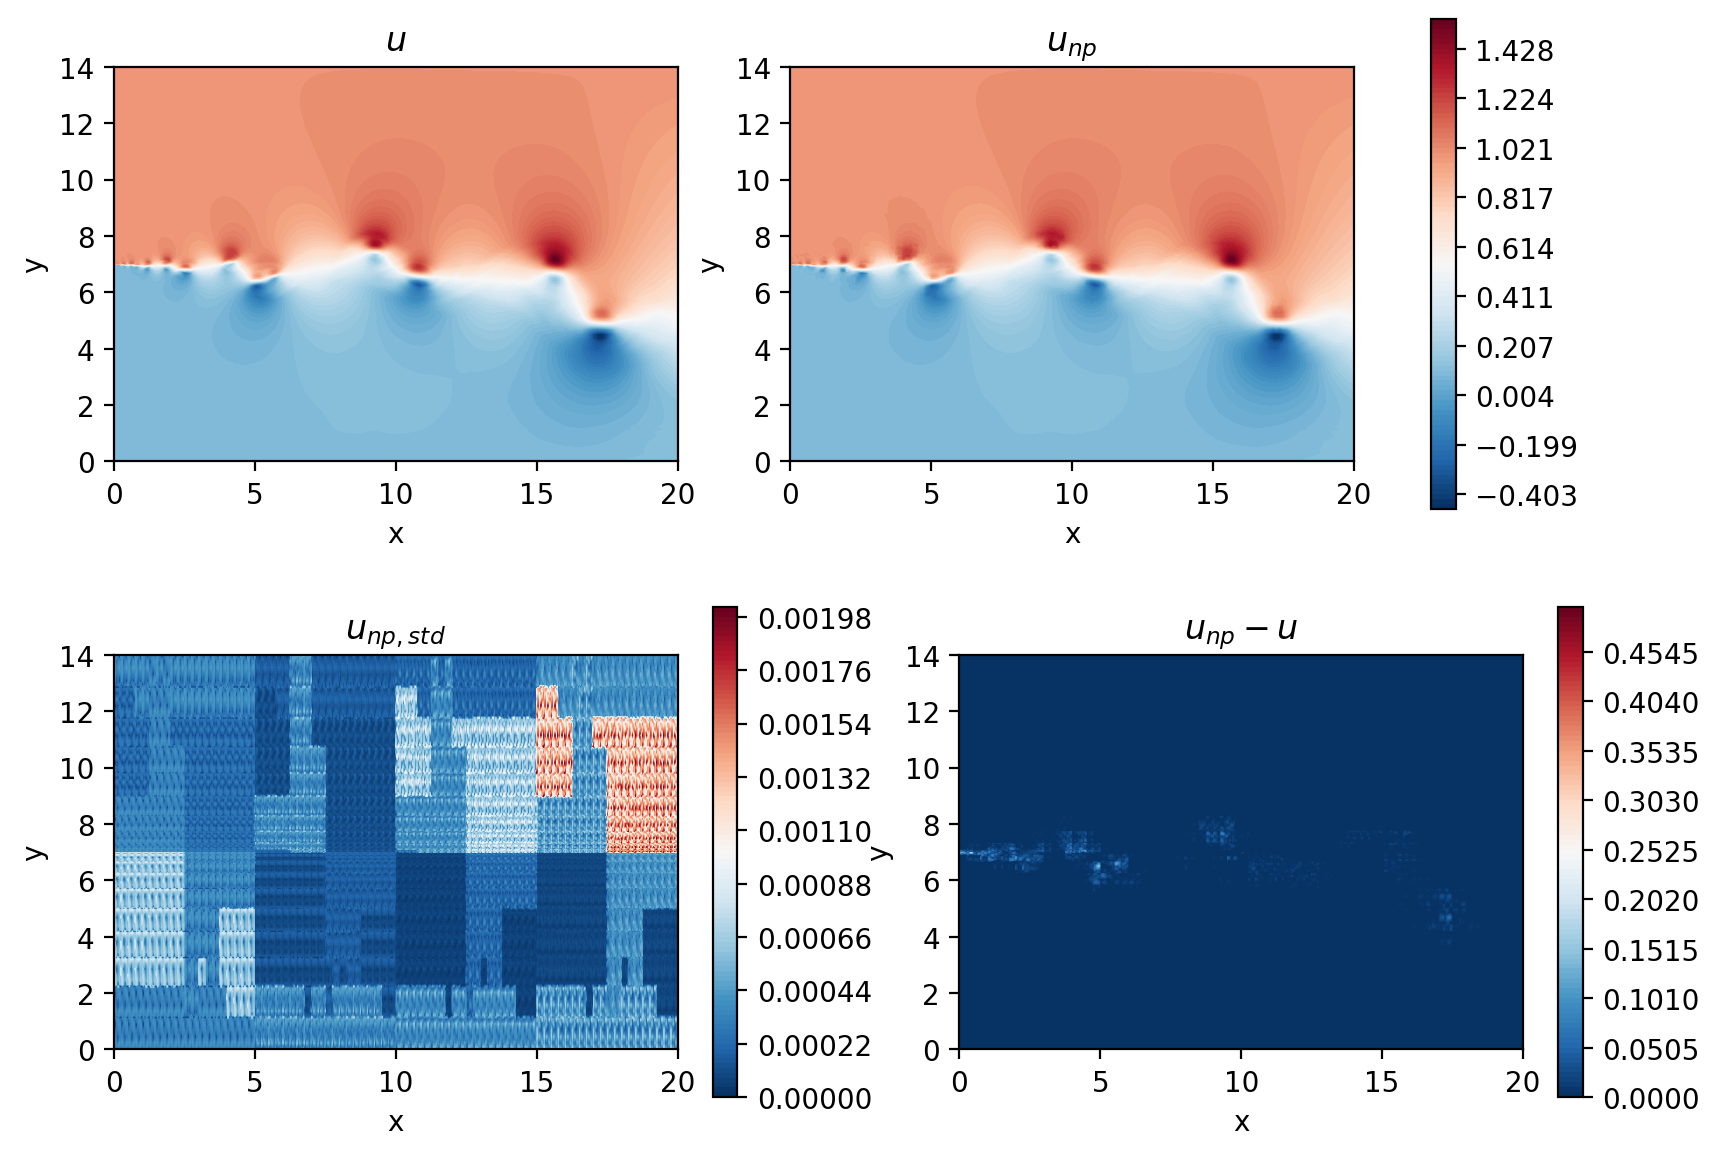

In [11]:


fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 7), dpi = 200)

c00 = ax[0,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,fld.registry["u"].flatten(), levels=u_levels, cmap="RdBu_r")
ax[0,0].set_aspect('equal')
ax[0,0].set_xlabel("x")
ax[0,0].set_ylabel("y")
ax[0,0].set_title(r"$u$")

c01 = ax[0,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,u_np.flatten(), levels=u_levels, cmap="RdBu_r")
ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel("x")
ax[0,1].set_ylabel("y")
ax[0,1].set_title(r"$u_{np}$")

c10 = ax[1,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,u_std_np.flatten(), levels=100, cmap="RdBu_r")
ax[1,0].set_aspect('equal')
ax[1,0].set_xlabel("x")
ax[1,0].set_ylabel("y")
ax[1,0].set_title(r"$u_{np,std}$")

c11 = ax[1,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,np.sqrt((u_np.flatten()- u.flatten())**2), levels=err_levels, cmap="RdBu_r")
ax[1,1].set_aspect('equal')
ax[1,1].set_xlabel("x")
ax[1,1].set_ylabel("y")
ax[1,1].set_title(r"$u_{np} - u$")

cbar0=fig.colorbar(c00, ax=ax[0,:])
cbar10=fig.colorbar(c10, ax=ax[1,0])
cbar11=fig.colorbar(c11, ax=ax[1,1])
plt.show()

### Torch

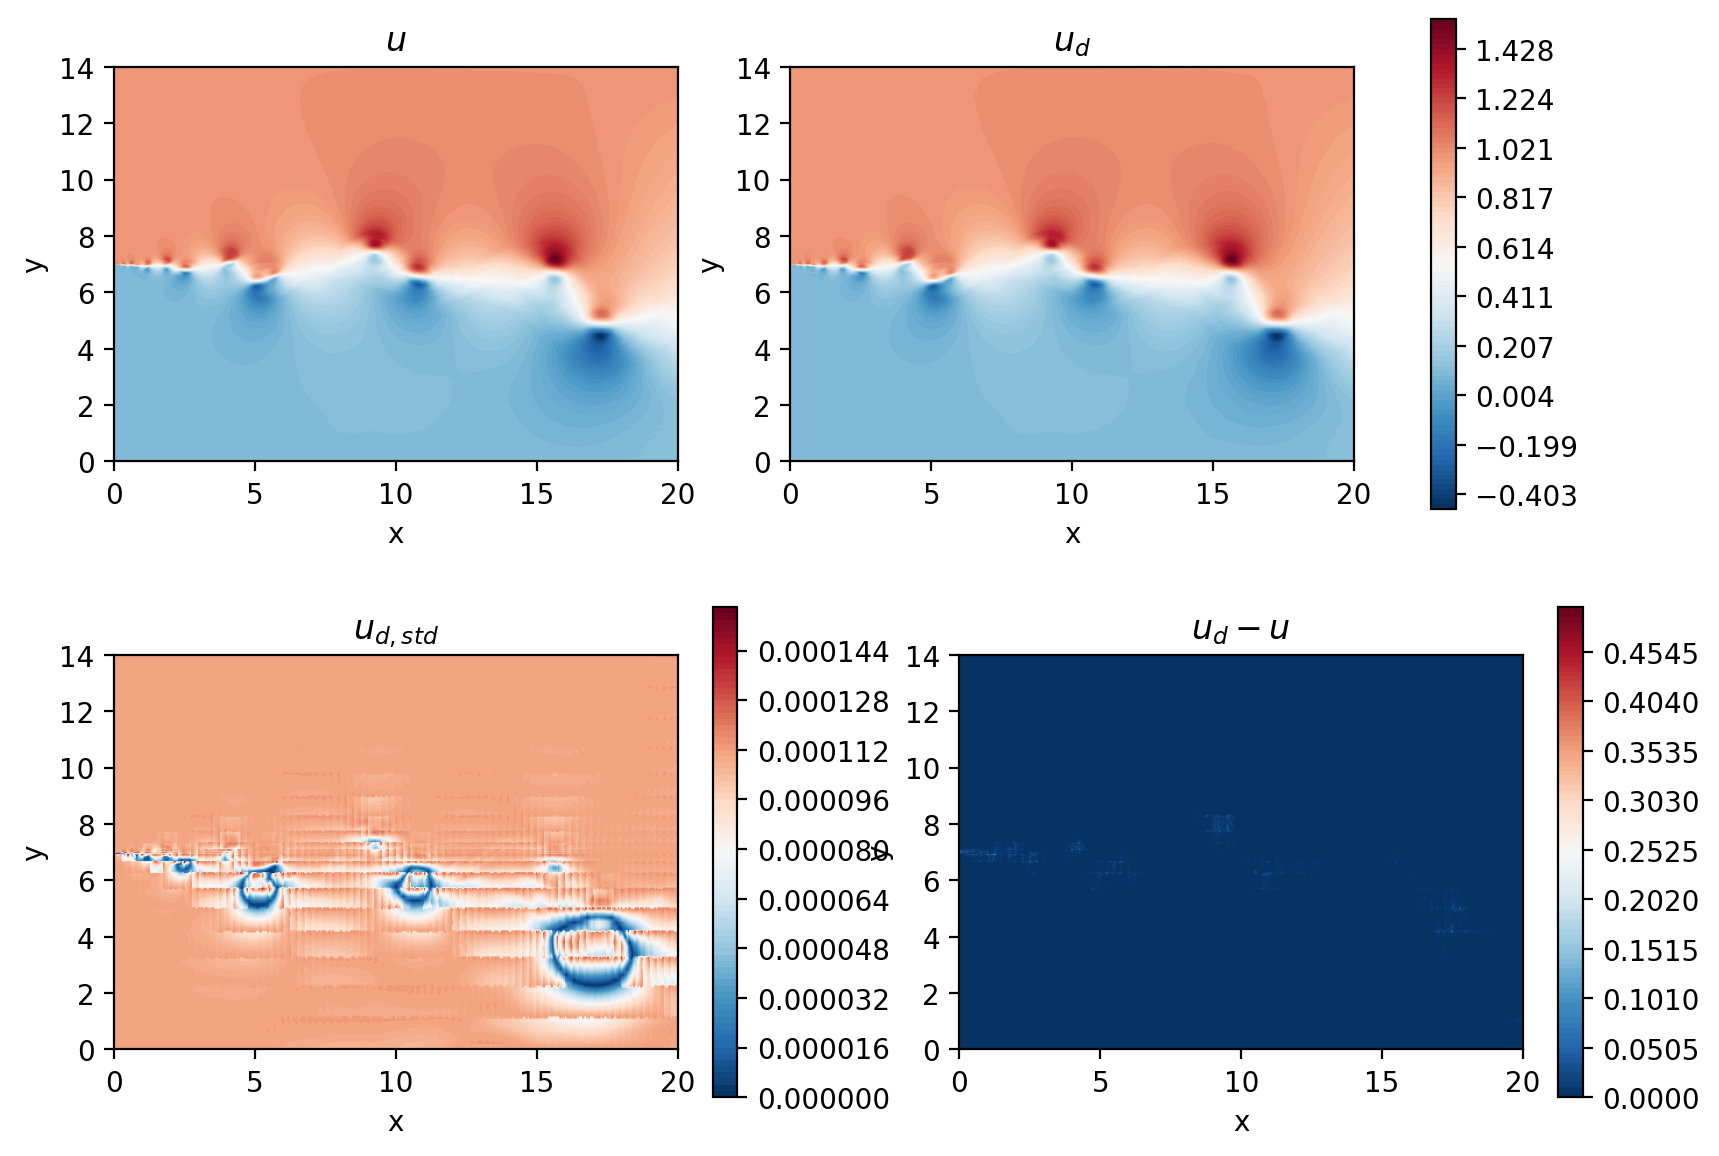

In [12]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 7), dpi = 200)

c00 = ax[0,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,fld.registry["u"].flatten(), levels=u_levels, cmap="RdBu_r")
ax[0,0].set_aspect('equal')
ax[0,0].set_xlabel("x")
ax[0,0].set_ylabel("y")
ax[0,0].set_title(r"$u$")

c01 = ax[0,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,u_d.flatten(), levels=u_levels, cmap="RdBu_r")
ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel("x")
ax[0,1].set_ylabel("y")
ax[0,1].set_title(r"$u_{d}$")

c10 = ax[1,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,u_std_d.flatten(), levels=100, cmap="RdBu_r")
ax[1,0].set_aspect('equal')
ax[1,0].set_xlabel("x")
ax[1,0].set_ylabel("y")
ax[1,0].set_title(r"$u_{d,std}$")

c11 = ax[1,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,np.sqrt((u_d.cpu().numpy().flatten()- u.flatten())**2), levels=err_levels, cmap="RdBu_r")
ax[1,1].set_aspect('equal')
ax[1,1].set_xlabel("x")
ax[1,1].set_ylabel("y")
ax[1,1].set_title(r"$u_{d} - u$")

cbar0=fig.colorbar(c00, ax=ax[0,:])
cbar10=fig.colorbar(c10, ax=ax[1,0])
cbar11=fig.colorbar(c11, ax=ax[1,1])
plt.show()

## Test the derivative

In [13]:
# Initiate the mesh partitioning
from pysemtools.datatypes.msh_connectivity import MeshConnectivity

msh_conn = MeshConnectivity(comm, msh = msh, use_hashtable=True)

dudx = coef.dudxyz(u, coef.drdx, coef.dsdx)
dudy = coef.dudxyz(u, coef.drdy, coef.dsdy)

dudx_np = coef.dudxyz(u_np, coef.drdx, coef.dsdx)
dudy_np = coef.dudxyz(u_np, coef.drdy, coef.dsdy)

dudx_d = coef.dudxyz(u_d.cpu().numpy(), coef.drdx, coef.dsdx)
dudy_d = coef.dudxyz(u_d.cpu().numpy(), coef.drdy, coef.dsdy)

dudx_levels = np.linspace(-2.5, 3.1, 100)
dudy_levels = np.linspace(-4.6, 7.6, 100)

2025-02-25 16:06:23,923 - MeshConnectivity - INFO - Initializing MeshConnectivity
2025-02-25 16:06:23,927 - MeshConnectivity - INFO - Computing local connectivity
2025-02-25 16:06:24,092 - MeshConnectivity - INFO - Computing global connectivity
2025-02-25 16:06:24,093 - MeshConnectivity - INFO - Computing multiplicity
2025-02-25 16:06:24,117 - MeshConnectivity - INFO - MeshConnectivity initialized
2025-02-25 16:06:24,118 - MeshConnectivity - INFO - Elapsed time: 0.19136693400000127s
2025-02-25 16:06:24,119 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-02-25 16:06:24,131 - Coef - INFO - done
2025-02-25 16:06:24,132 - Coef - INFO - Elapsed time: 0.01263638300000025s
2025-02-25 16:06:24,133 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-02-25 16:06:24,144 - Coef - INFO - done
2025-02-25 16:06:24,145 - Coef - INFO - Elapsed time: 0.01127096700000152s
2025-02-25 16:06:24,146 - Coef - INFO - Calculating the derivati

### Numpy

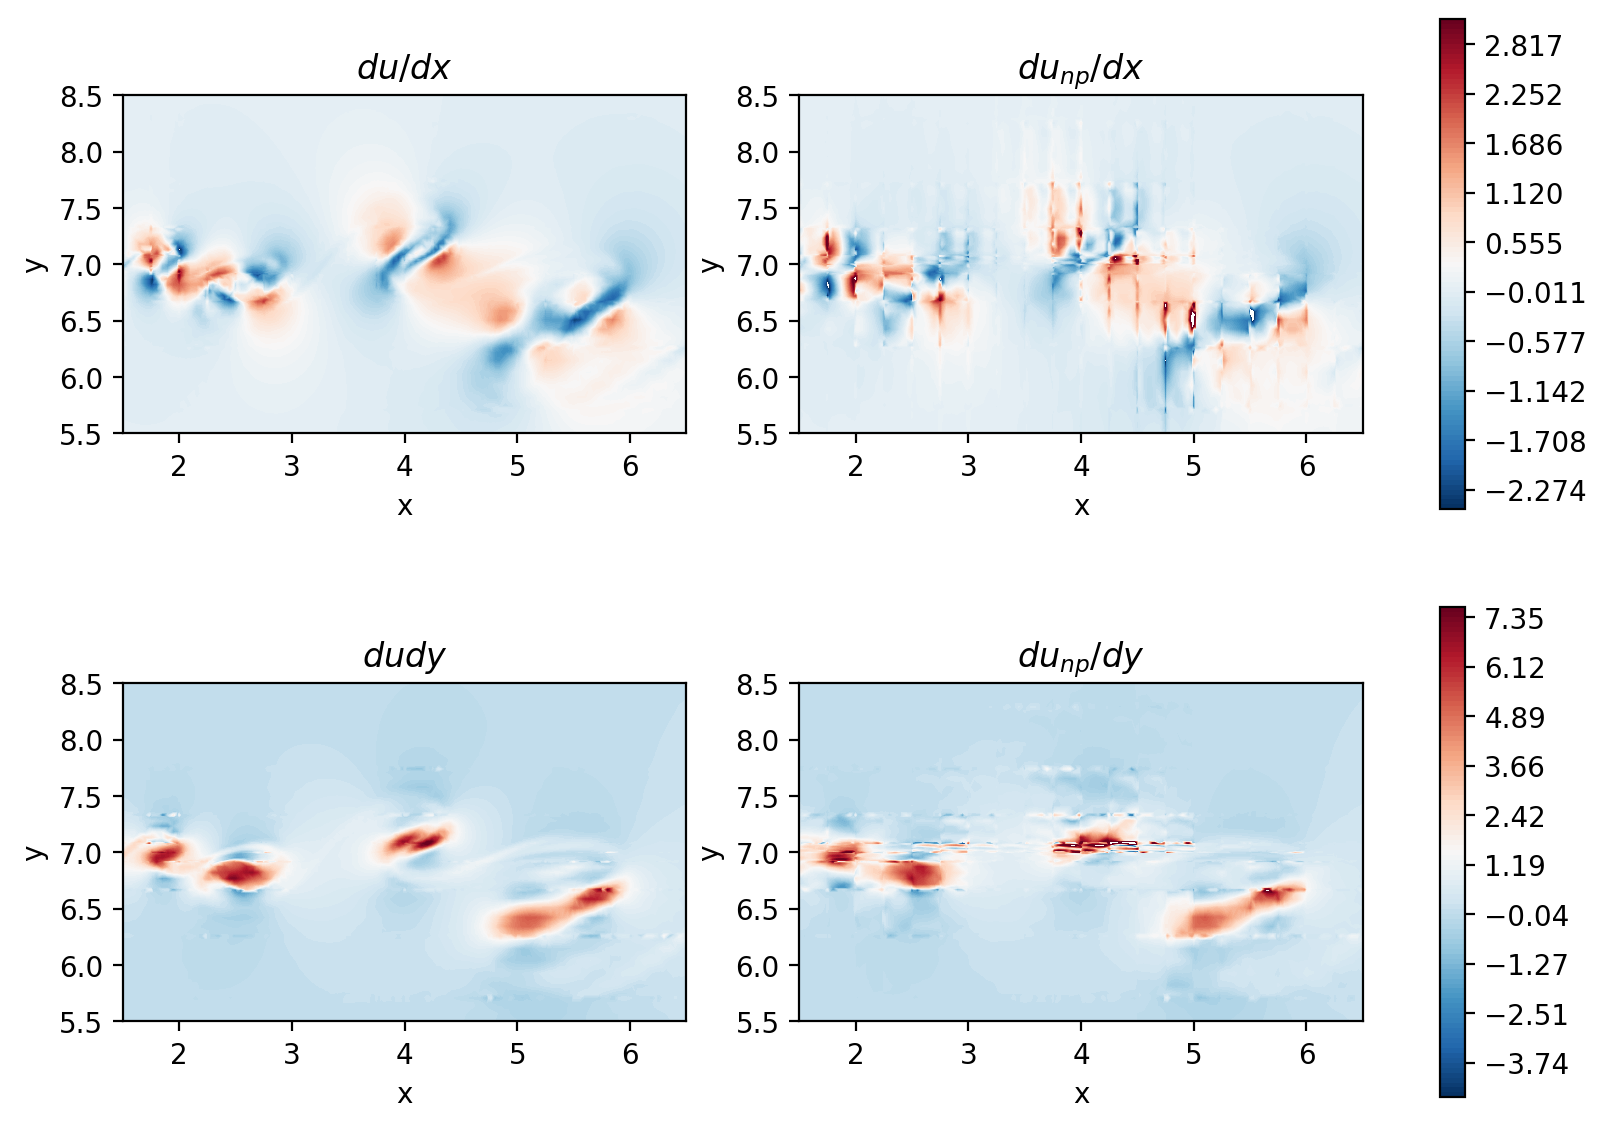

In [14]:

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 7), dpi = 200)

c00 = ax[0,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudx.flatten(), levels=dudx_levels, cmap="RdBu_r")
ax[0,0].set_aspect('equal')
ax[0,0].set_xlabel("x")
ax[0,0].set_ylabel("y")
ax[0,0].set_title(r"$du/dx$")

c01 = ax[0,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudx_np.flatten(), levels=dudx_levels, cmap="RdBu_r")
ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel("x")
ax[0,1].set_ylabel("y")
ax[0,1].set_title(r"$du_{np}/dx$")

c10 = ax[1,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudy.flatten(), levels=dudy_levels, cmap="RdBu_r")
ax[1,0].set_aspect('equal')
ax[1,0].set_xlabel("x")
ax[1,0].set_ylabel("y")
ax[1,0].set_title(r"$dudy$")

c11 = ax[1,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudy_np.flatten(), levels=dudy_levels, cmap="RdBu_r")
ax[1,1].set_aspect('equal')
ax[1,1].set_xlabel("x")
ax[1,1].set_ylabel("y")
ax[1,1].set_title(r"$du_{np}/dy$")

cbar0=fig.colorbar(c00, ax=ax[0,:])
cbar10=fig.colorbar(c10, ax=ax[1,:])


ax[0,0].set_xlim([1.5,6.5])
ax[0,0].set_ylim([5.5,8.5])

ax[0,1].set_xlim([1.5,6.5])
ax[0,1].set_ylim([5.5,8.5])

ax[1,0].set_xlim([1.5,6.5])
ax[1,0].set_ylim([5.5,8.5])

ax[1,1].set_xlim([1.5,6.5])
ax[1,1].set_ylim([5.5,8.5])

plt.show()

### Torch

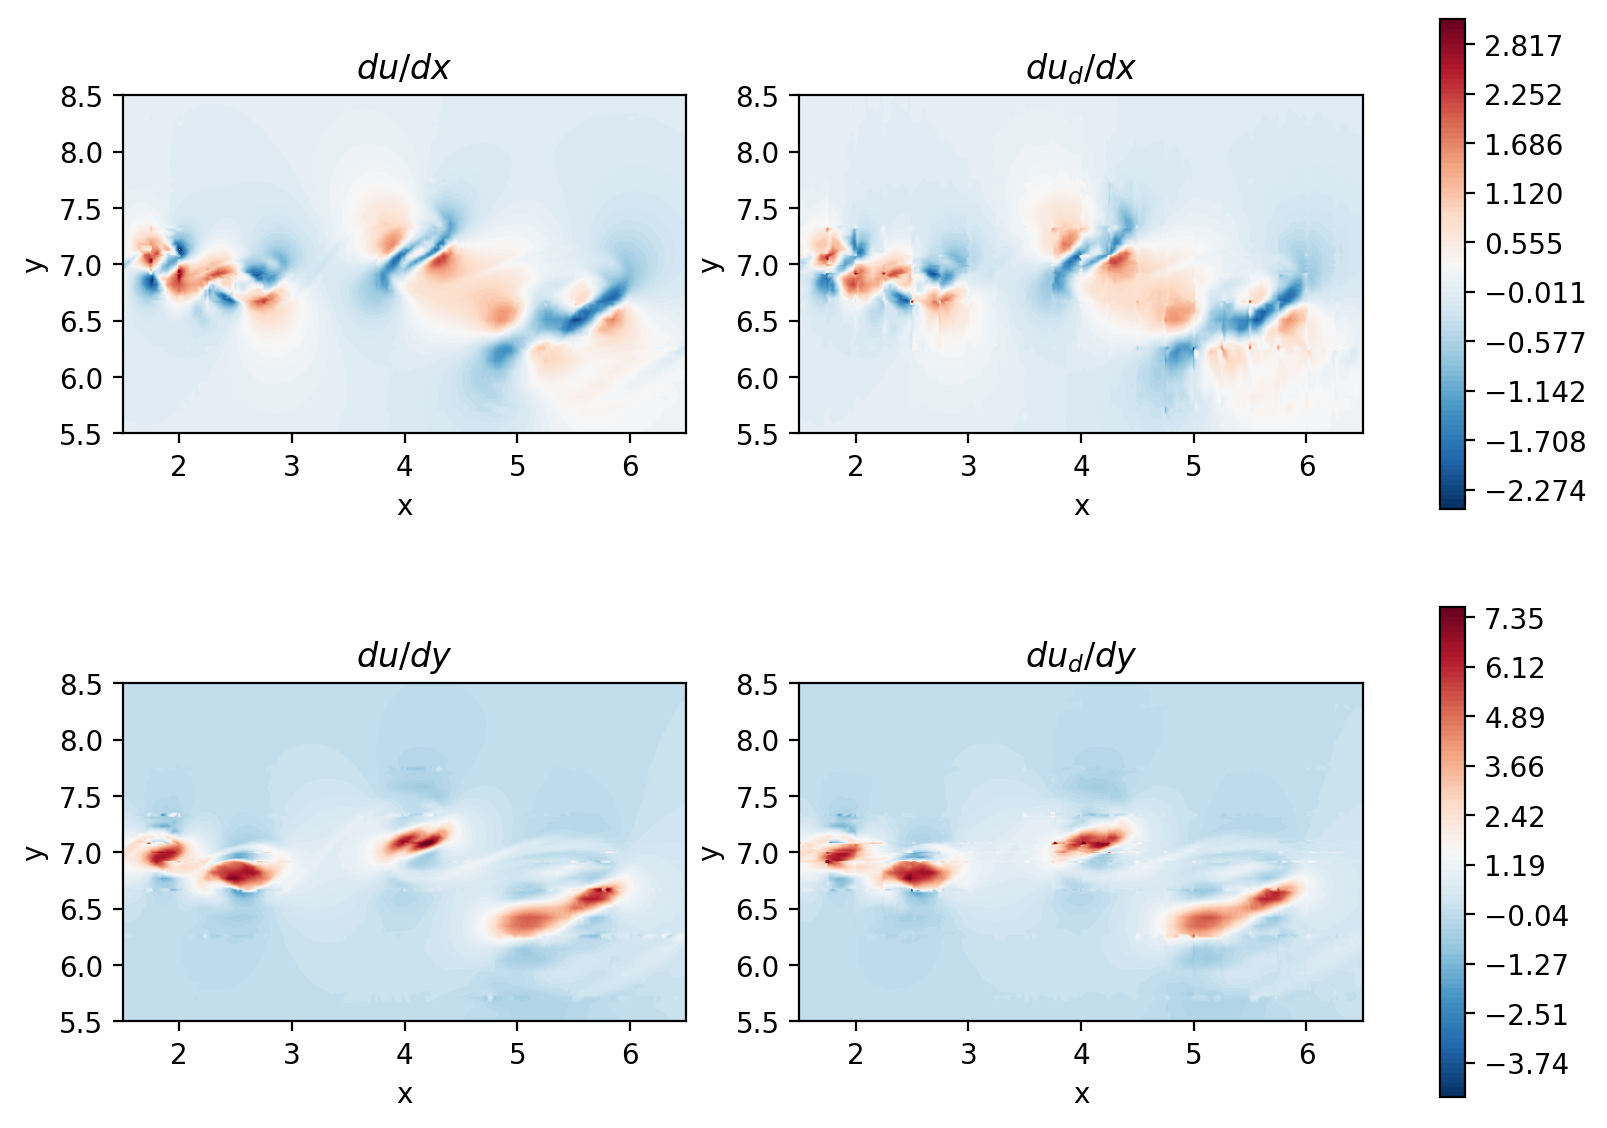

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 7), dpi = 200)

c00 = ax[0,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudx.flatten(), levels=dudx_levels, cmap="RdBu_r")
ax[0,0].set_aspect('equal')
ax[0,0].set_xlabel("x")
ax[0,0].set_ylabel("y")
ax[0,0].set_title(r"$du/dx$")

c01 = ax[0,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudx_d.flatten(), levels=dudx_levels, cmap="RdBu_r")
ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel("x")
ax[0,1].set_ylabel("y")
ax[0,1].set_title(r"$du_{d}/dx$")

c10 = ax[1,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudy.flatten(), levels=dudy_levels, cmap="RdBu_r")
ax[1,0].set_aspect('equal')
ax[1,0].set_xlabel("x")
ax[1,0].set_ylabel("y")
ax[1,0].set_title(r"$du/dy$")

c11 = ax[1,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudy_d.flatten(), levels=dudy_levels, cmap="RdBu_r")
ax[1,1].set_aspect('equal')
ax[1,1].set_xlabel("x")
ax[1,1].set_ylabel("y")
ax[1,1].set_title(r"$du_{d}/dy$")

cbar0=fig.colorbar(c00, ax=ax[0,:])
cbar10=fig.colorbar(c10, ax=ax[1,:])


ax[0,0].set_xlim([1.5,6.5])
ax[0,0].set_ylim([5.5,8.5])

ax[0,1].set_xlim([1.5,6.5])
ax[0,1].set_ylim([5.5,8.5])

ax[1,0].set_xlim([1.5,6.5])
ax[1,0].set_ylim([5.5,8.5])

ax[1,1].set_xlim([1.5,6.5])
ax[1,1].set_ylim([5.5,8.5])

plt.show()